![](https://miro.medium.com/max/691/0*xXUYOs5MWWenxoNz)

# Знакомство с PyTorch. Часть 2.  

## Анатомия нейронных сетей на PyTorch на примере полносвязной нейронной сети  

**Нейронная сеть** -- математическая модель, а также ее программные и аппаратные реализации, предназначенные для поиска неких полезных представлений данных в пространстве представлений. 

Как уже известно, нейронные сети состоят из следующих компонентов:
* **Данные** -- входные и выходные (а иногда только входные)  
* **Модель** нейронной сети, состоящая из **слоев**  
* **Весовые параметры** -- те параметры, которые непосредственно изменяются в процессе обучения  
* **Функция потерь** -- определяет, каким образом будут обновляться весовые параметры сети для достижения желаемых результатов  
* **Оптимизатор** -- непосредственно отвечает за обновление весовых коэффицинтов сети.  

Процесс обновления весовых параметров нейронной сети, при котором ошибка сети, характерищующаяся функцией потерь, стремится к минимуму, называется **обучением сети**  

Нагляднее всего процесс обучения представить в виде картинки ниже:  

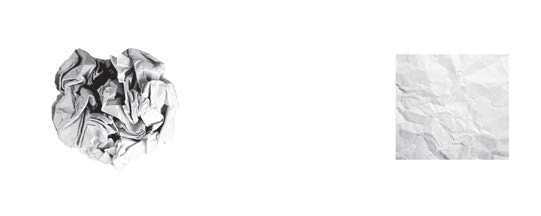


Пусть необходимо решить задачу классификации листов бумаги по цвету нейронной сетью. Пусть скомканные листы бумаги являются входными данными, а каждый лист бумаги принадлежит тому или иному классу цвета.  
Тогда суть ее работы сводится к постепенному преобразованию этого комка таким образом, чтобы классы стали явно различимыми.

Рассмотрим этапы построения нейронной сети на PyTorch на примере полносвязной нейронной сети для решения задачи классификации изображений одежды на основе набора данных Fashion-MNIST

### 1. Получение данных. Создание загрузчика данных  

Доступ к набору данных Fashion-MNIST можно получить непосредственно из PyTorch с помощью модуля `torchvision.datasets`  

В PyTorch имеется набор инструментов для загрузки и преобразования данных, упрощающий эта важные задачи в области Data Science, которые обычно отнимают очень много времени  

Помимо **тренировочного** набора данных необходимо обзавестить также **тестовым** (и, что еще лучше, **валидационным**) набором, т. к. необходимо получить модель, которая будет извлекать универсальные признаки из изображений вне зависимости от того, участвовали ли они в обучении или нет, т. .е необходимо получить **качественную** модель  

In [ ]:
import torchvision.datasets as dataset
import torchvision.transforms as transform

# создание объекта для транформации наборов данных
transforms = transform.Compose([
          transform.ToTensor(),
          transform.Normalize(
              (0.1307,), (0.3081,))
          
                                                         
])

# загрузка тренировочного набора данных Fashion-MNIST 
train_data = dataset.FashionMNIST(r"/content/FashionMNIST",
                                  train=True,
                                  download=True,
                                  transform=transforms,
                                  )

# загрузка тестового набора данных Fashion-MNIST
test_data = dataset.FashionMNIST(r"/content/FashionMNIST", 
                                 train=False,
                                 download=True,
                                 transform=transforms
                                 )

image, target = next(iter(train_data))
print(image.shape)

Extracting /content/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw


Extracting /content/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw



Extracting /content/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw


Extracting /content/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/FashionMNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!
torch.Size([1, 28, 28])





Выше был определены **наборы данных** с помощью класса FashionMNIST.  
Для собственных наборов данных рекомендуется реализовывать собственные классы, которые наследуются от класса `Dataset`  

Для загрузки данных в нейронную сеть необходимо создать **загрузчик данных**

In [ ]:
from torch.utils.data import DataLoader

# создание загрузчика данных для тренировочного набора
train_loader = DataLoader(train_data,
                          batch_size=16,
                          shuffle=True)

# создание загрузчика данных для тестового набора
test_loader = DataLoader(test_data,
                         batch_size=16,
                         shuffle=True)

### 2. Построение полносвязной нейронной сети на PyTorch  

**Полносвязные нейронные сети** являются одними из наиболее простых нейросетевых архитектур для решения задачи классификации изображений. 

В полносвязных нейронных сетях каждый нейрон предыдущего слоя связан с каждым нейроном следующего слоя.

Каждая связь имеет **вес**, который определяет ее  силу. Именно эти веса будут обновляться в процессе обучения. 

Когда входные данные проходят через сеть, происходит матричное умножение весовых параметров (и смещений) на них. Затем полученные величины поступают в **функцию активации**  
Она вводит элемент нелинейности и непосредственно формирует выходной сигнал слоя.  

Наиболее распространенные функции активации: ReLU, softmax, sigmoid  

Их реализации в случае с PyTorch хранятся в модуле `torch.nn.functional`

In [ ]:
import torch.nn.functional as F
print(dir(F))

['GRID_SAMPLE_INTERPOLATION_MODES', 'GRID_SAMPLE_PADDING_MODES', 'List', 'Optional', 'Tensor', 'Tuple', '_Reduction', '_VF', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_adaptive_max_pool1d', '_adaptive_max_pool2d', '_adaptive_max_pool3d', '_add_docstr', '_fractional_max_pool2d', '_fractional_max_pool3d', '_get_softmax_dim', '_infer_size', '_list_with_default', '_max_pool1d', '_max_pool2d', '_max_pool3d', '_no_grad_embedding_renorm_', '_overload', '_pad', '_pad_circular', '_pair', '_single', '_threshold', '_triple', '_unpool_output_size', '_verify_batch_size', 'adaptive_avg_pool1d', 'adaptive_avg_pool2d', 'adaptive_avg_pool3d', 'adaptive_max_pool1d', 'adaptive_max_pool1d_with_indices', 'adaptive_max_pool2d', 'adaptive_max_pool2d_with_indices', 'adaptive_max_pool3d', 'adaptive_max_pool3d_with_indices', 'affine_grid', 'alpha_dropout', 'assert_int_or_pair', 'avg_pool1d', 'avg_pool2d', 'avg_pool3d', 'batch_norm', 'bilinear', 'b

Создание полносвязной нейронной сети на PyTorch напоминает программирование на Python.  

В этом случае необходимо **создать класс** нашей нейронной сети, который **обязательно** должен быть унаследован от класса `torch.nn.Module`  

Это базовый класс для всех модулей нейронных сетей в PyTorch  

Затем в нем необходимо определить два метода: `__init__` и `forward` 

Метод `__init__` задает последовательность слоев сети  

Метод `forward` определяет, как данные будут передаваться по сети в процессе обучения и прогона)

In [ ]:
import torch.nn as nn

# создаем класс, реализующий полносвязную нейронную сеть
class FullyConnectedNeuralNetwork(nn.Module):

  # создаем последовательность слоев сети в конструкторе
  def __init__(self):
    super(FullyConnectedNeuralNetwork, self).__init__()
    # добавляем первый полносвязный слой, 
    # который будет иметь 784 входа (28x28x1) и 512 выходов 
    self.fc1 = nn.Linear(784, 512)
    # добавляем второй полносвязный слой,
    # который будет иметь 512 входов и 10 выходов
    self.fc2 = nn.Linear(512, 10)

  # реализовываем метод для прямого распространения сигналов по сети
  def forward(self, x):
    # преобразовать в одномерный тензор
    x = x.view(-1, 784)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


# создадим объект полносвязной сети
fcn = FullyConnectedNeuralNetwork()

# вывод структуры модели в консоль
print(fcn)


  




FullyConnectedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


В PyTorch реализовано большое многообразие слоев, которые используются как в известных архитектурах и которых можно использовать для построения своих архитектур. 

Все они содержатся в модуле `torch.nn`

In [ ]:
print(dir(nn))

['AdaptiveAvgPool1d', 'AdaptiveAvgPool2d', 'AdaptiveAvgPool3d', 'AdaptiveLogSoftmaxWithLoss', 'AdaptiveMaxPool1d', 'AdaptiveMaxPool2d', 'AdaptiveMaxPool3d', 'AlphaDropout', 'AvgPool1d', 'AvgPool2d', 'AvgPool3d', 'BCELoss', 'BCEWithLogitsLoss', 'BatchNorm1d', 'BatchNorm2d', 'BatchNorm3d', 'Bilinear', 'CELU', 'CTCLoss', 'ConstantPad1d', 'ConstantPad2d', 'ConstantPad3d', 'Container', 'Conv1d', 'Conv2d', 'Conv3d', 'ConvTranspose1d', 'ConvTranspose2d', 'ConvTranspose3d', 'CosineEmbeddingLoss', 'CosineSimilarity', 'CrossEntropyLoss', 'CrossMapLRN2d', 'DataParallel', 'Dropout', 'Dropout2d', 'Dropout3d', 'ELU', 'Embedding', 'EmbeddingBag', 'FeatureAlphaDropout', 'Flatten', 'Fold', 'FractionalMaxPool2d', 'FractionalMaxPool3d', 'GELU', 'GLU', 'GRU', 'GRUCell', 'GroupNorm', 'Hardshrink', 'Hardsigmoid', 'Hardswish', 'Hardtanh', 'HingeEmbeddingLoss', 'Identity', 'InstanceNorm1d', 'InstanceNorm2d', 'InstanceNorm3d', 'KLDivLoss', 'L1Loss', 'LPPool1d', 'LPPool2d', 'LSTM', 'LSTMCell', 'LayerNorm', 'Lea

Выше определена простейшая полносвязная нейронная сеть без скрытых слоев  

Теперь можно на основе входных данных формировать некие выходные прогнозы. Для количественного определения того, насколько верные прогнозы выдает сеть, используются **функции потерь** 

Реализации функций потерь в PyTorch также содержатся в модуле `torch.nn`

В контексте текущей задачи имеет смысл использовать функцию потерь `CrossEntropyLoss`, также часто используется и `MSELoss`



In [ ]:
loss_function = nn.CrossEntropyLoss()

Для выполнения обновления весовых параметров в сети используются **оптимизаторы**. или **функции оптимизации**  

Чаще всего используются функции оптимизации на основе **метода стохастического градиентного спуска (SGD)**.  
Реализация стандартного SGD, а также такие функции оптимизации, как `AdaGrad`, `Adam`, `RMSProp` имеются в модуле `torch.optim`  

В контексте задачи классификации изображений одежды будем использовать оптимизатор `Adam`  
Он принимает два аргумента:
* весовые параметры модели
* коэффициент обучения

In [ ]:
import torch.optim as optim 
optimizer = optim.Adam(fcn.parameters(), lr=0.001)

In [ ]:
print(dir(optim))

['ASGD', 'Adadelta', 'Adagrad', 'Adam', 'AdamW', 'Adamax', 'LBFGS', 'Optimizer', 'RMSprop', 'Rprop', 'SGD', 'SparseAdam', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_multi_tensor', 'functional', 'lr_scheduler', 'swa_utils']


Все необходимое для запуска обучения готово, теперь можно реализовать цикл обучения  

In [ ]:
# определяем количество эпох
epochs = 10
# запускаем цикл по количеству эпох
for epoch in range(epochs):
  # для каждого пакета в загрузчике тренировочного набора
  for batch in train_loader:
    # обнуляем градиенты
    optimizer.zero_grad()
    # берем пакет из набора
    input, target = batch
    # вычисляем прогнозы сети по пакету
    output = fcn(input)
    # вычисляем потери
    loss = loss_function(output, target)
    # вычисляем градиенты
    loss.backward()
    # корректируем весовые параметры
    optimizer.step()
  print("TRAINING")


В PyTorch из коробки поддерживается обучение нейронных сетей на GPU    
По умолчанию PyTorch выполняет вычисления на CPU, однако можно написать код, который позволяет выбирать GPU в случае если он установлен  

Перемещение входных тензоров и модели осуществляется с помощью метода `to()`

In [ ]:
import torch

device = None
# если GPU обнаружен
if torch.cuda.is_available():
  # устанавливаем его в качестве устройства
  device = torch.device("cuda:0")
else: # иначе
  # устанавливаем в качестве устройства GPU
  device = torch.device("cpu")

print(device)

# перемещение модели и тензоров на устройство
fcn.to(device)

cpu


FullyConnectedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

Создадим единый метод обучения `fit()`, который охватывает модель, процесс обучения и наборы данных

In [ ]:
def fit(model, 
          optimizer, 
          loss_function, 
          train_loader, 
          test_loader, 
          epochs, 
          device,
         ):
    # определяем количество батчей в тренировочной выборке
    total_step = len(train_loader)
    
    
    # пускаем цикл по эпохам
    for epoch in range(epochs):
        train_loss = 0
        # для каждого батча в тренировочном наборе
        for i, batch in enumerate(train_loader):  
            # извлекаем изображения и их метки
            images, labels = batch
            # отправляем их на устройство
            images = images.to(device)
            labels = labels.to(device)
            # вычисляем выходы сети
            outputs = fcn(images)
            # вычисляем потери на батче
            loss = loss_function(outputs, labels)
            # обнуляем значения градиентов
            optimizer.zero_grad()
            # вычисляем значения градиентов на батче
            loss.backward()
            # корректируем веса
            optimizer.step()
            
            # корректируем значение потерь на эпохе
            train_loss += loss.item()
            
            # логируем
            if (i+1) % 500 == 0:
                print ('Эпоха [{}/{}], Шаг [{}/{}], Тренировочные потери: {:.4f}' 
                       .format(epoch+1, 5, i+1, total_step, loss.data.item()))
                
        
    # режим тестирования модели
    # для тестирования вычислять градиенты не обязательно, поэтому оборачиваем код
    # для теста в блок with torch.no_grad()
    with torch.no_grad():
        # заводим начальные значения корректно распознанных примеров и общего количества примеров
        correct = 0
        total = 0
        # для каждого батча в тестовой выборкй
        for batch in test_loader:
            # извлекаем изображения и метки
            images, labels = batch
            # помещаем их на устройство
            images = images.to(device)
            labels = labels.to(device)
            # вычисление предсказаний сети
            outputs = fcn(images)
            # создание тензора предсказаний сети
            _, predicted = torch.max(outputs.data, 1)
            # корректировка общего значения примеров на величину батча
            total += labels.size(0)
            # корректировка значения верно классифицированных примеров
            correct += (predicted == labels).sum().item()
        
        # логирование
        print('Точность на тестовом наборе {} %'.format(100 * correct / total))

In [ ]:
epochs = 5

fit(fcn,
     optimizer,
     loss_function,
     train_loader,
     test_loader,
     epochs,
     device)

Эпоха [1/5], Шаг [500/3750], Тренировочные потери: 0.7490
Эпоха [1/5], Шаг [1000/3750], Тренировочные потери: 0.3516
Эпоха [1/5], Шаг [1500/3750], Тренировочные потери: 0.8756
Эпоха [1/5], Шаг [2000/3750], Тренировочные потери: 0.1108
Эпоха [1/5], Шаг [2500/3750], Тренировочные потери: 0.3422
Эпоха [1/5], Шаг [3000/3750], Тренировочные потери: 0.4551
Эпоха [1/5], Шаг [3500/3750], Тренировочные потери: 0.5541
Эпоха [2/5], Шаг [500/3750], Тренировочные потери: 0.2408
Эпоха [2/5], Шаг [1000/3750], Тренировочные потери: 0.3105
Эпоха [2/5], Шаг [1500/3750], Тренировочные потери: 0.1593
Эпоха [2/5], Шаг [2000/3750], Тренировочные потери: 0.6406
Эпоха [2/5], Шаг [2500/3750], Тренировочные потери: 0.2305
Эпоха [2/5], Шаг [3000/3750], Тренировочные потери: 0.6889
Эпоха [2/5], Шаг [3500/3750], Тренировочные потери: 0.4692
Эпоха [3/5], Шаг [500/3750], Тренировочные потери: 0.1931
Эпоха [3/5], Шаг [1000/3750], Тренировочные потери: 0.6977
Эпоха [3/5], Шаг [1500/3750], Тренировочные потери: 0.6680


Таким образом, мы обучили полносвязную нейронную сеть для классификации изображений одежды  

И теперь ее можно использовать для прогнозирования

In [ ]:
# список классов 
labels = train_data.classes

# возьмем пример из тестового набора
image, label = next(iter(test_data))

# формируем предсказания
predictions = fcn(image)
prediction = predictions.argmax()
print("Предсказание: ", labels[prediction])
print("Метка:", labels[label])

Предсказание:  Ankle boot
Метка: Ankle boot


Если по каким-либо причинам поизводительность и точность модели устраивают (или необходимо приостановить работу), то можно сохранить обученную модель на диск  

В PyTorch имеется "из коробки" возможность сохранения моделей, причем несколькими способами  

Первый способ заключается в сохранении текущего состояния модели в формате консервации (pickle) с помощью метода `torch.save()`  
Также можно загрузить ранее сохраненную итерацию модели, используя метод `torch.load()`  


In [ ]:
# сохранение текущих параметров сети
torch.save(fcn, "/content/fcn")

In [ ]:
# загрузка текущего состояние сети
fcn = torch.load("/content/fcn")
print(fcn)

FullyConnectedNeuralNetwork(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


Таким образом сохраняется текущая структура нейронной сети в файл  

Если по какой-либо причине структура изменится, то на этапе загрузки модели могут возникнуть сложности  

В связи с этим более распространенной практикой является использование `state_dict`. Это словарь Python, который содержит состояния параметров каждого слоя в модели 

In [ ]:
# сохранение state_dict
torch.save(fcn.state_dict(), "/content/fcn_1")

In [ ]:
# восстановление модели  
fcn = FullyConnectedNeuralNetwork()
fcn_state_dict = torch.load("/content/fcn_1")
fcn.load_state_dict(fcn_state_dict)

<All keys matched successfully>